In [24]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import unicodedata
from io import open
import string
import re
import random

In [25]:
# loading data into the program
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Checking directory of data files
!ls; cd /content/drive/My\ Drive/Machine\ Translation; ls


drive  my_cp.pth.tar  sample_data
english_sampled.txt  en_hi.pkl	hindi_sampled.txt


In [28]:
SOS = 0
EOS = 1

class Language_Prepare:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"}
    self.n_words = 2

  def processCorpus(self, sentence):
    for word in sentence.split(' '):
      if word not in self.word2index:
        self.word2index[word] = self.n_words
        self.word2count[word] = 1
        self.index2word[self.n_words] = word
        self.n_words = self.n_words + 1
      
      else:
        self.word2count[word] += 1


In [29]:
# load data

import pandas as pd
df = pd.read_pickle('/content/drive/My Drive/Machine Translation/en_hi.pkl')

df.head()

,english,hindi
57382,Who is this man?\n,-ये आदमी कौन है ?\n
28149,And the other brother?\n,और दूसरे भाई?\n
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n"
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n"
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n


In [30]:
# preprocessing

exclude = set(string.punctuation)

df['english'] = df['english'].apply(lambda x: x.lower())
df['hindi'] = df['hindi'].apply(lambda x: x.lower())

df['english'] = df['english'].apply(lambda x: re.sub("'", '', x))
df['hindi'] = df['hindi'].apply(lambda x: re.sub("'", '', x))

df['english'] = df['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hindi'] = df['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

df['english'] = df['english'].apply(lambda x : x[:-1])
df['hindi'] = df['hindi'].apply(lambda x : x[:-1])

df['english'] = df['english'].apply(lambda x : x.strip())
df['hindi'] = df['hindi'].apply(lambda x : x.strip())

df['english'] = df['english'].apply(lambda x: re.sub(" +", " ", x))
df['hindi'] = df['hindi'].apply(lambda x: re.sub(" +", " ", x))

# df['hindi'] = df['hindi'].apply(lambda x: str(SOS) + ' ' + x + ' ' + str(EOS))

In [31]:
df.head()

,english,hindi
57382,who is this man,ये आदमी कौन है
28149,and the other brother,और दूसरे भाई
80284,greetings mustakeen bhai,नमस्ते mustakeen भाई।
63596,please reason with them,कृपया उन लोगों के साथ कारण
9459,theres a howling gale,तेज़ हवा आ रही है।


In [32]:
MAX = 50

def filter(eng, hin):
  pairs = []
  if len(eng.split(' ')) < MAX and len(hin.split(' ')) < MAX:
    # pair = []
    pairs.append(eng)
    pairs.append(hin)
    # pairs.append(pair)

  return pairs


def preprocessSentences():
  # pairs = [normalizeString(s) for s in engl]
  pairs = []
  for i in range(len(df)):
    pairs.append(filter(df.iloc[i]['english'], df.iloc[i]['hindi']))
  
  hindi = Language_Prepare('hin')
  english = Language_Prepare('eng')

  # print(len(df))

  for i in range(len(pairs)):
  # for pair in pairs:
    # print(pair)
    english.processCorpus(pairs[i][0])
    hindi.processCorpus(pairs[i][1])
  
  print(hindi.name, hindi.n_words)
  print(english.name, english.n_words)
  print(pairs)
  return pairs, english, hindi

pairs, english, hindi = preprocessSentences()

train_dataset, test_dataset = torch.utils.data.random_split(pairs, [7000, 3000])
test_dataset, validation_dataset = torch.utils.data.random_split(test_dataset, [2000, 1000])
# print(train_dataset)
# print(len(train_dataset))

hin 6791
eng 5602
[['who is this man', 'ये आदमी कौन है'], ['and the other brother', 'और दूसरे भाई'], ['greetings mustakeen bhai', 'नमस्ते mustakeen भाई।'], ['please reason with them', 'कृपया उन लोगों के साथ कारण'], ['theres a howling gale', 'तेज़ हवा आ रही है।'], ['no you dont', 'नहीं कभी नहीं'], ['the violence the rage', 'हिंसा स्पूर्ति।'], ['signal decoy in place', 'सिग्नल जगह में लूभाव।'], ['you guys come with', 'तुम लोग इसे ले तो आये हो'], ['how long you staying', 'तुम कब तक रह'], ['who is this now', 'अब यह कौन है'], ['hows rosie doing jim', 'कैसे रोजी जिम कर रहा है'], ['100 feet radius clear', '100 फुट त्रिज्या स्पष्ट'], ['its not safe', 'वहाँ खतरा है।'], ['trevor no no dont', 'नहीं नहीं नहीं करते हैं'], ['your passport is ready', 'आपका पासपोर्ट तैयार है।'], ['come on lets go', 'चलो चलते हैं।'], ['fruit of thy womb', 'तुम्हारे पेट का फल'], ['agh that is tight', 'तंग है कि आह'], ['is this wool', 'यह ऊन है'], ['no she is different', 'नहीं है वह अलग है।'], ['ask any of them', 'उनमें स

In [33]:
# building the encoder from here
%matplotlib inline

class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, inval, hidden):
    embedded = self.embedding(inval).view(1,1,-1)
    outval = embedded
    outval, hidden = self.gru(outval, hidden)
    return outval, hidden


In [34]:
# building the decoder
%matplotlib inline

class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, inval, hidden):
    outval = self.embedding(inval).view(1,1,-1)
    outval = F.relu(outval)
    outval, hidden = self.gru(outval, hidden)
    outval = self.softmax(self.out(outval[0]))
    return outval, hidden


In [35]:
def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(english, pair[0])
  target_tensor = tensorFromSentence(hindi, pair[1])
  return (input_tensor, target_tensor)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX):
  teacher_f = 0.5
  encoder_hidden = torch.zeros(1,1,encoder.hidden_size,device=device)

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

  loss = 0

  for ei in range(0, input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0,0]

  decoder_input = torch.tensor([[SOS]], device=device)

  decoder_hidden = encoder_hidden

  use_tf = True if random.random() < teacher_f else False
  
  for di in range(0, target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    loss += criterion(decoder_output, target_tensor[di])
    decoder_input = target_tensor[di]

  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [36]:
# plotting the results

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

In [37]:
def run_training(encoder, decoder, n_iters, eta, plot_every=1000):
  plot_losses = []
  print_loss = 0
  plot_loss = 0

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=eta)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=eta)
  training_pairs = [tensorsFromPair(random.choice(train_dataset)) for i in range(0, n_iters)]

  criterion = nn.NLLLoss()

  for iter in range(1, n_iters+1):
    print(f"[Epoch {iter} / {n_iters}]")

    checkpoint = {
        "encoder": encoder.state_dict(),
        "optimizer_encoder": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "optimizer_decoder": decoder_optimizer.state_dict()
    }

    torch.save(checkpoint, "/content/drive/My Drive/Machine Translation/my_cp.pth.tar")

    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    print_loss += loss
    plot_loss += loss

    if iter%plot_every == 0:
      plotAverage = plot_loss / plot_every
      plot_losses.append(plotAverage)
      plot_loss = 0

  showPlot(plot_losses)


[Epoch 1 / 4000]
[Epoch 2 / 4000]
[Epoch 3 / 4000]
[Epoch 4 / 4000]
[Epoch 5 / 4000]
[Epoch 6 / 4000]
[Epoch 7 / 4000]
[Epoch 8 / 4000]
[Epoch 9 / 4000]
[Epoch 10 / 4000]
[Epoch 11 / 4000]
[Epoch 12 / 4000]
[Epoch 13 / 4000]
[Epoch 14 / 4000]
[Epoch 15 / 4000]
[Epoch 16 / 4000]
[Epoch 17 / 4000]
[Epoch 18 / 4000]
[Epoch 19 / 4000]
[Epoch 20 / 4000]
[Epoch 21 / 4000]
[Epoch 22 / 4000]
[Epoch 23 / 4000]
[Epoch 24 / 4000]
[Epoch 25 / 4000]
[Epoch 26 / 4000]
[Epoch 27 / 4000]
[Epoch 28 / 4000]
[Epoch 29 / 4000]
[Epoch 30 / 4000]
[Epoch 31 / 4000]
[Epoch 32 / 4000]
[Epoch 33 / 4000]
[Epoch 34 / 4000]
[Epoch 35 / 4000]
[Epoch 36 / 4000]
[Epoch 37 / 4000]
[Epoch 38 / 4000]
[Epoch 39 / 4000]
[Epoch 40 / 4000]
[Epoch 41 / 4000]
[Epoch 42 / 4000]
[Epoch 43 / 4000]
[Epoch 44 / 4000]
[Epoch 45 / 4000]
[Epoch 46 / 4000]
[Epoch 47 / 4000]
[Epoch 48 / 4000]
[Epoch 49 / 4000]
[Epoch 50 / 4000]
[Epoch 51 / 4000]
[Epoch 52 / 4000]
[Epoch 53 / 4000]
[Epoch 54 / 4000]
[Epoch 55 / 4000]
[Epoch 56 / 4000]
[

<Figure size 432x288 with 0 Axes>

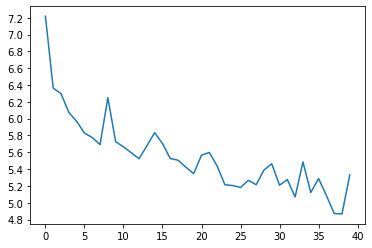

In [38]:
# running training
%matplotlib inline

hidden_size = 256
encoder1 = EncoderRNN(english.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, hindi.n_words).to(device)

run_training(encoder1, decoder1, 4000, 0.01, plot_every=100)

In [39]:
# Evaluate model

def evaluate(encoder, decoder, sentence, MAX=50):
  with torch.no_grad():
    input_tensor = tensorFromSentence(english, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = torch.zeros(1, 1, encoder.hidden_size, device=device)
    encoder_outputs = torch.zeros(MAX, encoder.hidden_size, device=device)

    for ei in range(0, input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0,0]
    
    decoder_input = torch.tensor([[SOS]], device=device) 
    decoder_hidden = encoder_hidden

    hindi_words = []

    for di in range(0,MAX):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      topv, topi = decoder_output.data.topk(1)

      if topi.item() == EOS:
        hindi_words.append('')
        break
        
      else:
        hindi_words.append(hindi.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()

    return hindi_words

def evaluateRandomly(encoder, decoder, n):
  for i in range(0,n):
    pair = test_dataset[i]
    print('English: ', pair[0])
    
    output_words = evaluate(encoder, decoder, pair[0], 50)
    sentenceOut = ' '.join(output_words)

    print('Hindi predicted: ', sentenceOut)

    act = pair[1].split()
    pred = sentenceOut.split()

    from nltk.translate.bleu_score import sentence_bleu
    score = sentence_bleu([act], pred)
    print(score)


In [41]:
%matplotlib inline
evaluateRandomly(encoder1, decoder1, 2000)

English:  where is the girls body
Hindi predicted:  यह एक भी है 
0.5506953149031838
English:  just back from the cusp
Hindi predicted:  मैं भी नहीं कर सकता है 
0
English:  didnt you get it
Hindi predicted:  मैं तुम्हें भी नहीं कर सकता है 
0.6147881529512643
English:  she will follow her star
Hindi predicted:  मैं एक भी नहीं कर सकता है 
0
English:  so put the gun down
Hindi predicted:  मैं एक भी नहीं कर सकता है 
0.6147881529512643
English:  i cant believe this
Hindi predicted:  मैं मैं भी नहीं कर सकता है 
0.8091067115702212
English:  names and records arent enough
Hindi predicted:  मैं एक भी नहीं कर सकता है 
0.6147881529512643
English:  yeah its pretty cool
Hindi predicted:  यह एक भी है 
0
English:  i gotta rest
Hindi predicted:  मैं मैं भी नहीं कर सकता है 
0.6147881529512643
English:  you tell me
Hindi predicted:  तुम मुझे लगता है 
0.7071067811865476
English:  and that was your mates
Hindi predicted:  और और भी नहीं कर रहे हैं 
0
English:  man speaking native language
Hindi predicted:  

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
0.7311104457090247
English:  you schedule a delivery
Hindi predicted:  तुम क्या कर रहे हो 
0
English:  i brought you some news
Hindi predicted:  मैं तुम्हें भी नहीं कर सकता है 
0.4671379777282001
English:  i will find him
Hindi predicted:  मैं मैं भी नहीं कर सकता है 
0.6147881529512643
English:  sad flutinas or something
Hindi predicted:  मैं एक भी नहीं कर सकता है 
0
English:  carly look at me okay
Hindi predicted:  मैं इसे भी नहीं कर सकता है 
0.6147881529512643
English:  whats that light up there
Hindi predicted:  तो यह मेरी है 
0.5506953149031838
English:  no hes not here
Hindi predicted:  मैं यहाँ से बाहर 
0.5506953149031838
English:  his computer his emails
Hindi predicted:  मैं एक भी नहीं कर सकता है 
0
English:  mobile phone ringing
Hindi predicted:  और कुछ भी नहीं है 
0
English:  stop swinging the bat
Hindi predicted:  तो मैं एक साथ 
0
English:  rodrigue likes overhearing childrens stories
Hindi predicted:  मैं एक भी नहीं कर सकता